In [151]:
import numpy as np
from scipy.interpolate import BarycentricInterpolator
from scipy.integrate import quad
from scipy.stats import norm
from chebyshev_interpolator_sj import ChebyshevInterpolation
from Option_sj import OptionType, EuropeanOption
from quadrature_nodes_sj import QuadratureNodes
from utils import QDplus
import matplotlib.pyplot as plt

## Define Variables to being with
l = 5
n =5
max_tau =1 
strike = 100
riskfree = 0.025
dividend = 0.025
volatility = 0.25
option_type = OptionType.Put
X = strike*min(1,riskfree/dividend)
initial_boundary = np.zeros(n+1)

cheby = ChebyshevInterpolation(5,1)
cheby.compute_nodes()
tau_nodes = cheby.tau_nodes

## 2. compute the Quadrature nodes and weights
quadrature = QuadratureNodes(l)
quadrature.compute_legendre_nodes()
y_nodes, w_weights = quadrature.get_nodes_and_weights()

## 3. compute initial boundary using QD Plus
a=QDplus(riskfree, dividend, volatility, strike, option_type)
for i in range(len(tau_nodes)):
    initial_boundary[i] = a.compute_exercise_boundary(tau_nodes[i])

###  compute q(_initial_boundary), since H_x = q_z           # Perhaps can be put to Utils 
def B_to_q(_initial_boundary):
    """
    Compute H(sqrt(tau)) for each collocation point based on the previous boundary values.

    Returns:
    - H_values (numpy array): The computed H(sqrt(tau)) values.
    """
    q_values = np.square((np.log(_initial_boundary / X)))

    return q_values

## compute b(_q_values) to obtain the reverse                # Perhaps can be put to Utils 
def q_to_B(_q_values):
    """
    Given that H_values = q
    From q/H_values calculate B

    Returns:
    - B_values (numpy array): The computed B(tau) values.
    """
    B_values = np.zeros(len(_q_values))
    for i in range(len(_q_values)):
        if _q_values[i] < 1: ### When q_value is less than 1 it means that log(B(tau)/X) was negative value
            B_values[i] = X * np.exp(-np.sqrt(_q_values[i]))
        else:
            B_values[i] = X * np.exp(np.sqrt(_q_values[i]))

    return B_values

## 4.1 initialize_chebyshev_interpolation to compute coefficients a_k
# Here do note n is 5 and we need to have n+1 nodes 
def Cheby_interpolant(q):
    a = np.zeros(n + 1)
    for k in range(n + 1):
        ans = 0
        for i in range(n + 1):
            term = q[i] * np.cos(i * k * np.pi / n)
            if i == 0 or i == n:
                term *= 0.5
            ans += term
        ans *= (2.0 / n)
        a[k] = ans
    return a

def clenshaw_algorithm(z, a_coefficients):
    """
    Evaluate the Chebyshev polynomial using Clenshaw's algorithm.

    Parameters:
    - z (float): The input value to evaluate the polynomial.

    Returns:
    - (float): The evaluated value of the Chebyshev polynomial.
    """
    b0 = a_coefficients[n] * 0.5
    b1 = 0
    b2 = 0

    for k in range(n - 1, -1, -1):
        b1, b2 = b0, b1
        b0 = a_coefficients[k] + 2 * z * b1 - b2
    return 0.5 * (b0 - b2)


In [4]:
## Define Variables to being with
l = 5
n = 5
max_tau =1 
strike = 100
riskfree = 0.025
dividend = 0.025
volatility = 0.25
option_type = OptionType.Put
X = strike*min(1,riskfree/dividend)


In [161]:
EuropeanOption.european_put_value(max_tau, strike, riskfree, dividend, volatility, strike)

9.702036736700578

In [5]:
## 1. Obtain Chebyshev nodes to begin
cheby = ChebyshevInterpolation(n,1)
cheby.compute_nodes()
tau_nodes = cheby.get_nodes()[1]

## Fill up rest of the variables
initial_boundary = np.zeros(n+1)

## print tau_nodes
print(initial_boundary, tau_nodes)

[0. 0. 0. 0. 0. 0.] [1.         0.81813562 0.42838137 0.11936438 0.00911863 0.        ]


In [7]:
## 2. compute the Quadrature nodes and weights
quadrature = QuadratureNodes(l)
quadrature.compute_legendre_nodes()
y_nodes, w_weights = quadrature.get_nodes_and_weights()
y_nodes, w_weights

(array([-0.90617985, -0.53846931,  0.        ,  0.53846931,  0.90617985]),
 array([0.23692689, 0.47862867, 0.56888889, 0.47862867, 0.23692689]))

In [13]:
## 3. compute initial boundary using QD Plus
a=QDplus(riskfree, dividend, volatility, strike, option_type) 
for i in range(len(tau_nodes)):
    initial_boundary[i] = a.compute_exercise_boundary(tau_nodes[i])

print(initial_boundary)

[ 62.08739664  64.05178323  70.10034581  80.23115496  92.55238125
 100.        ]


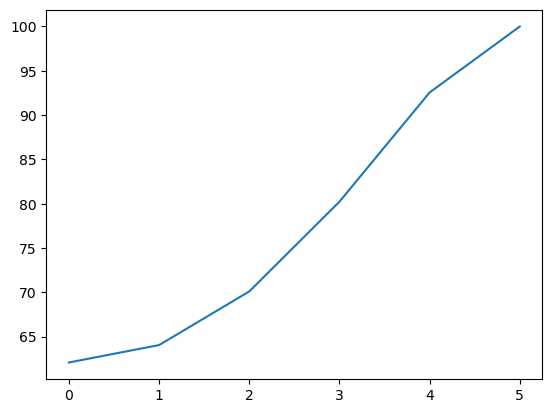

In [15]:
plt.plot(initial_boundary)

In [17]:
## compute q(_initial_boundary), since H_x = q_z 
def B_to_q(_initial_boundary):
    """
    Compute H(sqrt(tau)) for each collocation point based on the previous boundary values.

    Returns:
    - H_values (numpy array): The computed H(sqrt(tau)) values.
    """
    q_values = (np.log(_initial_boundary / X)) ** 2 

    return q_values

## compute b(_q_values) to obtain the reverse 
def q_to_B(_q_values):
    """
    Given that H_values = q
    From q/H_values calculate B

    Returns:
    - B_values (numpy array): The computed B(tau) values.
    """
    B_values = np.zeros(len(_q_values))
    for i in range(len(_q_values)):
        if _q_values[i] < 1: ### When q_value is less than 1 it means that log(B(tau)/X) was negative value
            B_values[i] = X * np.exp(-np.sqrt(_q_values[i]))
        else:
            B_values[i] = X * np.exp(np.sqrt(_q_values[i]))

    return B_values



In [19]:
## Test to interpolate the original points

a_coefficients = Cheby_interpolant(B_to_q(initial_boundary)) # obtain a_coefficients that will be used for interpolation

### Test for Clenshaw for inpterolation by ensuring that q(zi) can be obtained for the given zi of the intial boundary 

q = B_to_q(initial_boundary) # obtain the H_values (or q values) from intial boundary
z_i = cheby.z_nodes # obtain the z_i that we will try to interpolate


for i in range(len(z_i)):
    print(q[i], max(clenshaw_algorithm(z_i[i], a_coefficients),0))

0.2271734595026403 0.22717345950264034
0.198450930791562 0.19845093079156204
0.12619720456489988 0.1261972045648999
0.048513710245539916 0.04851371024553992
0.005990050719288737 0.005990050719288738
0.0 1.734723475976807e-17


In [21]:
## 4.1 initialize_chebyshev_interpolation to compute coefficients a_k
"""
Initialize the Chebyshev interpolation by computing the coefficients a_k.
"""
def Cheby_interpolant(_q):
    a = np.zeros(n + 1)
    for k in range(n + 1):
        ans = 0
        for i in range(n + 1):
            term = q[i] * np.cos(i * k * np.pi / n)
            if i == 0:
                term *= 0.5
            elif i == n:
                term *= ((-1)**n)*0.5
            ans += term
        ans *= (2.0 / n)
        a[k] = ans
    return a


In [23]:
def clenshaw_algorithm(z, a_coefficients):
    b0 = a_coefficients[n] * 0.5
    b1 = 0
    b2 = 0

    for k in range(n - 1, -1, -1):
        b1, b2 = b0, b1
        b0 = a_coefficients[k] + 2 * z * b1 - b2
    return 0.5 * (b0 - b2)

In [243]:
### Test for Clenshaw for inpterolation by ensuring that I can obtain q(zi) for the given zi of the intial boundary 

q = B_to_q(initial_boundary) # obtain the q from intial boundary
z_i = cheby.z_nodes # obtain the z_i that we will try to interpolate

test_a_coefficients = Cheby_interpolant(B_to_q(initial_boundary)) # obtain a_coefficients that will be used for interpolation

for i in range(len(z_i)):
    print(q[i], max(clenshaw_algorithm(z_i[i], a_coefficients),0))

# z_i, initial_boundary

0.2271734595026403 0.22717345950264034
0.198450930791562 0.19845093079156204
0.12619720456489988 0.1261972045648999
0.048513710245539916 0.04851371024553992
0.005990050719288737 0.005990050719288738
0.0 1.734723475976807e-17


In [241]:
# tau_nodes, initial_boundary

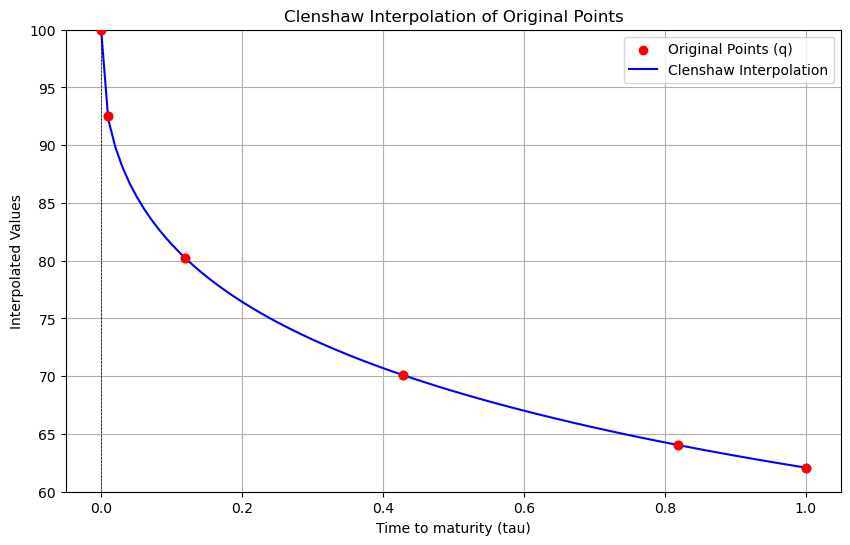

In [59]:
###### Test for the smoothness of the Interpolation 


# Generate points for interpolation
x_values = np.linspace(0, max_tau, 100)  # 100 points between min and max of tau_i
z_values = ((np.sqrt(x_values)*2)/(np.sqrt(max(tau_nodes))))-1
interpolated_values = [clenshaw_algorithm(x, a_coefficients) for x in z_values]

interpolated_values = q_to_B(interpolated_values)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot original points
plt.scatter(tau_nodes, initial_boundary, color='red', label='Original Points (q)', zorder=5)
plt.plot(tau_nodes, initial_boundary, 'ro')  # Optionally draw lines connecting original points

# Plot interpolated values
plt.plot(x_values, interpolated_values, label='Clenshaw Interpolation', color='blue')

# Add labels and title
plt.title('Clenshaw Interpolation of Original Points')
plt.xlabel('Time to maturity (tau)')
plt.ylabel('Interpolated Values')
plt.axhline(0, color='black', linewidth=0.5, ls='--')  # Add horizontal line at y=0
plt.axvline(0, color='black', linewidth=0.5, ls='--')  # Add vertical line at x=0
plt.legend()
plt.grid()

# Show the plot
plt.ylim(60,100)
plt.show()

In [63]:
z_values_for_red_points = ((np.sqrt(tau_nodes) * 2) / (np.sqrt(max(tau_nodes)))) - 1
interpolated_at_red_points = [clenshaw_algorithm(z, a_coefficients) for z in z_values_for_red_points]
interpolated_at_red_points = q_to_B(interpolated_at_red_points)
interpolated_at_red_points

array([62.08739664, 64.05178323, 70.10034581, 80.23115496, 92.55238125,
       99.99999958])

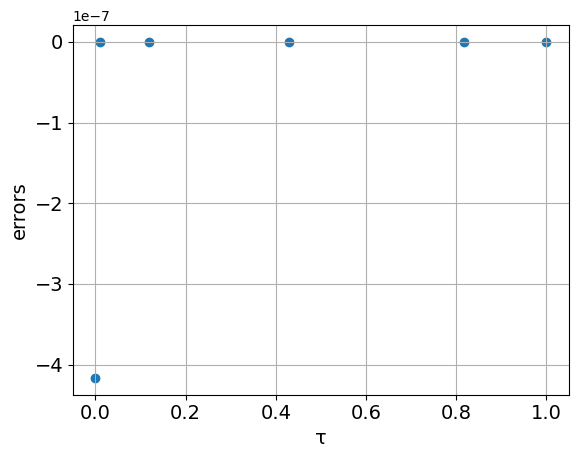

In [274]:
diff = interpolated_at_red_points - initial_boundary
#       )
plt.scatter(tau_nodes, diff)
plt.grid()
# plt.legend(fontsize=12) 

plt.ylabel('errors', fontsize=14)
plt.xlabel('τ', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14) 

plt.show()

In [135]:
## 4.3 Def Interpolation scheme to be used for quadrature later
# This means that we would be obtaining for tau - tau(1+y)**2/4

def evaluate_boundary(tau, y_nodes, a_coefficients): # change to l?

    ## For each tau we hope to obtain a series of nodes
    qz_interpolated = np.zeros(len(y_nodes))
    
    # Use the quadrature nodes obtained in the quadacture earlier
    for k, y_k in enumerate(y_nodes):
        adjusted_tau = tau - tau * (1 + y_k)**2 / 4               # Obtain the adjusted tau for each y_k, but the adjusted tau cannot be negative
        z = 2 * np.sqrt(adjusted_tau / max_tau) - 1             # From the tau obtain the z value
        qz_interpolated[k] = max(clenshaw_algorithm(z, a_coefficients),0) # Interpolate qz using the clenshaw algorithm

    B_values = q_to_B(qz_interpolated)                                    # q(z) = H(xi) to back out B_value for the z

    return B_values

In [171]:
## Test Evaluate Boudary

for tau in tau_nodes:
    print(evaluate_boundary(tau, y_nodes, a_coefficients))

# last row: ~100

[62.10899705 62.62409379 64.89484897 70.52644006 81.99907998]
[64.07322496 64.58317356 66.80917465 72.26902085 83.26065742]
[70.1199491  70.58519098 72.59971802 77.47138612 86.85671305]
[80.24636743 80.60661848 82.14808983 85.73285894 92.00306561]
[92.55879663 92.71006341 93.34339327 94.73552906 96.95755745]
[99.99999958 99.99999958 99.99999958 99.99999958 99.99999958]


In [173]:
# Before Calculating the Integrand ensure that d1 and d2 can be calculated / Also in the option class
# riskfree, dividend, strike, volatility should be defined externally, so the funciton depends only on tau and s0
def d1(tau, z):
    return (np.log(z) + (riskfree - dividend)*tau + 0.5 * volatility * volatility * tau)/(volatility * np.sqrt(tau))

def d2(tau, z):
    return (np.log(z) + (riskfree - dividend)*tau - 0.5 * volatility * volatility * tau)/(volatility * np.sqrt(tau))

In [175]:
# Obtain K1 for each tau(i)

def K1_integrad (tau, B, yk_nodes, B_y):
    k = len(yk_nodes)
    K1integrads = np.zeros(k)

    for i,yk in enumerate(yk_nodes):
        term0 = 0.25 * tau * (1 + yk)**2
        term1 = np.exp(-dividend * term0)
        term2 = (1 + yk)
        term3 = norm.cdf(d1(term0, B / B_y[i]))
        # Debugging prints
        K1integrads[i] = term1 * term2 * term3
    return K1integrads


def K1(tau, B_tau, yk, wk):
    B_yk = evaluate_boundary(tau, yk, a_coefficients)
    integrad = K1_integrad(tau, B_tau, y_nodes, B_yk)
    return tau*np.exp(dividend*tau)*0.5*sum(integrad*w_weights)



In [177]:
def K2_integrad (tau, B_tau, yk_nodes, B_y):
    k = len(yk_nodes)
    K2integrads = np.zeros(k)
   
    for i in range(k):
        term0 = tau / 4 * (1 + yk_nodes[i])**2
        term1 = (np.exp(-dividend * term0))/volatility
        term2 = norm.pdf(d1(term0, B_tau/B_y[i]))
        K2integrads[i] = term1*term2
    return K2integrads

def K2(tau, B_tau, y_nodes, w_weights):
    B_yk = evaluate_boundary(tau, y_nodes, a_coefficients)
    integrad = K2_integrad(tau, B_tau, y_nodes, B_yk)
    return tau*np.exp(dividend*tau)*sum(integrad*w_weights)

In [179]:
def K3_integrand(tau, B_tau, yk_nodes, B_y):
    k = len(yk_nodes)
    K3integrads = np.zeros(k)

    for i in range(k):
        term0 = 0.25 * tau *(1 + yk_nodes[i])**2
        term1 = (np.exp(-riskfree * term0))/volatility
        term2 = norm.pdf(d2(term0, B_tau/B_y[i]))
        K3integrads[i] = term1*term2
    return K3integrads

def K3(tau, B_tau, y_nodes, w_weights):
    B_yk = evaluate_boundary(B_tau, y_nodes, a_coefficients)
    integrad = K3_integrand(tau, B_tau, y_nodes, B_yk)
    return tau*np.exp(riskfree*tau)*sum(integrad*w_weights)

In [181]:
def N(tau, Beta):
    return norm.pdf(d2(tau, Beta/strike))/(volatility*np.sqrt(tau)) + riskfree*K3(tau, Beta, y_nodes, w_weights)

def D(tau, Beta):
    return norm.cdf(d1(tau,Beta/strike)) + norm.pdf(d1(tau, Beta/strike))/(volatility*np.sqrt(tau)) + dividend*(K1(tau, Beta,y_nodes, w_weights) + K2(tau, Beta,y_nodes, w_weights))

def f(tau,Beta):
    return strike*np.exp(-(riskfree-dividend)*tau)*N(tau,Beta)/D(tau,Beta)

## Approximation of NPrime
def Nprime(tau,B):
    return -d2(tau, B/strike) * norm.pdf(d2(tau, B/strike)) / (B * volatility * volatility * tau)

## Approximation of DPrime
def DPrime(tau,B):
    return -d2(tau, B/strike) * norm.pdf(d1(tau, B/strike)) / (B * volatility * volatility * tau)

def fprime(tau,B):
    return strike*np.exp(-(riskfree-dividend)*tau)*(Nprime(tau,B)/D(tau,B) - DPrime(tau,B)*N(tau,B)/(D(tau,B)**2))

In [183]:
N(tau_nodes[1], initial_boundary[1])

0.20271452378574067

In [185]:
D(tau_nodes[1], initial_boundary[1])

0.4112108464833847

In [187]:
f(tau_nodes[1], initial_boundary[1])

49.29697879307557

In [193]:
tau_nodes

array([1.        , 0.81813562, 0.42838137, 0.11936438, 0.00911863,
       0.        ])

In [308]:
def calculate_v_integrand_12(tau_nodes, B_tau_values, S, K, option_type, r, q, sigma):
    """
    Calculate v_integrand_12 for all tau using direct integration.

    Parameters:
    - tau_nodes: Array of tau_i values
    - B_tau_values: 2D array of B(tau) values, shape (n, l)
    - S: Current stock price
    - K: Strike price
    - option_type: 'Put' or 'Call'
    - r, q: Risk-free rate and dividend yield
    - sigma: Volatility

    Returns:
    - v_integrand_12_final: Array of v_integrand_12 values for each tau
    """
    n = len(tau_nodes)

    # Initialize the array to store v_integrand_12 values
    v_integrand_12_final = np.zeros(n)

    for i, tau in enumerate(tau_nodes):
        # Define the integrand function
        def v_integrand(u):
            if u < 0 or u > tau:
                return 0  # Return 0 for invalid u values

            # Interpolate B(u) for the current tau using the first column of B_tau_values
            B_u = np.interp(u, tau_nodes, B_tau_values[:, 0])

            # Compute v_integrand_12
            z_ratio = S / B_u  # Ratio S / B(u)
            if option_type == OptionType.Put:
                term_1 = r * K * np.exp(-r * (tau - u)) * norm.cdf(-d2(tau - u, z_ratio))
                term_2 = q * S * np.exp(-q * (tau - u)) * norm.cdf(-d1(tau - u, z_ratio))
                return term_1 - term_2
            else:  # Call option
                term_1 = q * S * np.exp(-q * (tau - u)) * norm.cdf(d1(tau - u, z_ratio))
                term_2 = r * K * np.exp(-r * (tau - u)) * norm.cdf(d2(tau - u, z_ratio))
                return term_1 - term_2

        # Perform numerical integration for the given tau
        v_integrand_12_final[i], _ = quad(v_integrand, 0, tau)

    return v_integrand_12_final


In [310]:
# assume we iterated & found B_u
def generate_B_tau_values(tau_nodes, y_nodes, a_coefficients):
    """
    Generate B_tau_values as a matrix using evaluate_boundary.

    Parameters:
    - tau_nodes: Array of tau_i values (1D array).
    - y_nodes: Gauss-Legendre quadrature nodes.
    - a_coefficients: Chebyshev coefficients for interpolation.

    Returns:
    - B_tau_values: 2D numpy array where each row corresponds to evaluated B(tau) for a tau in tau_nodes.
    """
    n = len(tau_nodes)
    l = len(y_nodes)

    # Initialize the matrix to store B_tau_values
    B_tau_values = np.zeros((n, l))

    for i, tau in enumerate(tau_nodes):
        # Evaluate boundary for each tau
        B_tau_values[i, :] = evaluate_boundary(tau, y_nodes, a_coefficients)

    return B_tau_values



In [312]:
B_tau_values = generate_B_tau_values(tau_nodes, y_nodes, a_coefficients)
print("B_tau_values:\n", B_tau_values)

B_tau_values:
 [[62.10899705 62.62409379 64.89484897 70.52644006 81.99907998]
 [64.07322496 64.58317356 66.80917465 72.26902085 83.26065742]
 [70.1199491  70.58519098 72.59971802 77.47138612 86.85671305]
 [80.24636743 80.60661848 82.14808983 85.73285894 92.00306561]
 [92.55879663 92.71006341 93.34339327 94.73552906 96.95755745]
 [99.99999958 99.99999958 99.99999958 99.99999958 99.99999958]]


In [314]:
v_integrand_12_final = calculate_v_integrand_12(tau_nodes=tau_nodes, 
                        B_tau_values=B_tau_values,
                         S=strike, 
                         option_type=option_type, 
                         r=riskfree, 
                         q=dividend, 
                         K=strike, 
                         sigma=volatility)
v_integrand_12_final

/var/folders/9w/7ggsrk6x71535t12wbfkj3k00000gn/T/ipykernel_34861/997629047.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(z) + (riskfree - dividend)*tau - 0.5 * volatility * volatility * tau)/(volatility * np.sqrt(tau))
/var/folders/9w/7ggsrk6x71535t12wbfkj3k00000gn/T/ipykernel_34861/997629047.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(z) + (riskfree - dividend)*tau + 0.5 * volatility * volatility * tau)/(volatility * np.sqrt(tau))


array([1.63499971e-01, 1.21355611e-01, 4.62770343e-02, 6.84151867e-03,
       1.44719628e-04, 0.00000000e+00])

In [316]:
def calculate_american_option_price(S, K, r, q, sigma, tau_nodes, v_integrand_12_final, option_type="Put"):
    """
    Compute the price of an American option.
    
    Parameters:
    - S: Current stock price
    - K: Strike price
    - r: Risk-free interest rate
    - q: Dividend yield
    - sigma: Volatility
    - tau_nodes: Array of tau_i values
    - v_integrand_12_final: Early exercise premium contributions
    - option_type: OptionType
    
    Returns:
    - american_price: The calculated American option price
    """
    # Step 1: Compute European option price
    tau = max(tau_nodes)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)

    if option_type == OptionType.Put:
        european_price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1)
    else:  # Call option
        european_price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

    # Step 2: Integrate v_integrand_12_final
    # Calculate the differences in tau_nodes (assuming they are evenly spaced)
    delta_tau = np.diff(tau_nodes, prepend=0)  # Include delta_tau[0] = tau_nodes[0]
    total_premium = np.sum(v_integrand_12_final * delta_tau)

    # Step 3: Combine the results
    american_price = european_price + total_premium

    return american_price

In [318]:
calculate_american_option_price(tau_nodes=tau_nodes,
                                S=strike, 
                                option_type=option_type, 
                                 r=riskfree, 
                                 q=dividend, 
                                 K=strike, 
                                 sigma=volatility,
                                v_integrand_12_final=v_integrand_12_final)

9.823299673667824

In [ ]:

        # Initialize quadrature nodes for American Option Pricing
        self.pricing_quadrature = QuadratureNodes(p)
        self.pricing_quadrature.compute_legendre_nodes()
        self.yp_nodes, self.wp_weights = self.pricing_quadrature.get_nodes_and_weights()
        self.u = 0.5*self.tau_max*(1+y_u)
        self.Bu_pricing = None

    ### Transform (12) to be iterval of 1,-1
    def compute_pricing_points(self):
        qp_interpolated = np.zeros(len(self.yp_nodes))

        z = 2 * np.sqrt(self.pricing_tau_nodes / self.tau_max) - 1
        for u, y_u in enumerate(self.yp_nodes):
            adjusted_u = 0.5*self.tau_max*(1+y_u)
            z = 2 * np.sqrt(adjusted_u / self.tau_max) - 1             # From the tau obtain the z value
            self.Bu_pricing[u] = self.q_to_B(max(self.clenshaw_algorithm(z, self.chebyshev_coefficients),0))
        

    def compute_pricing_integral_1(self):
       exp(-r*(max_tau - u))*norm.cdf(-d2(max_tau -u, S/Bu_pricing))

    def compute_pricing_integral_2(self):        
       exp(-q*(max_tau - u))*norm.cdf(-d1(max_tau -u, S/Bu_pricing))

       
